In [440]:
import pandas as pd
import gensim
import numpy as np
import random
import math

import gensim.downloader as api
import nltk
nltk.download("punkt")

from keras.layers import Dense, Dropout, GlobalAveragePooling1D, LSTM, Masking, TimeDistributed
from keras.models import Sequential
from matplotlib import pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gracebrown/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv('colornames.csv')

# Preprocessing

In [5]:
def hex_code_to_rgb(hex):
    """ Converts a color hex code to a tuple of values [0, 256] representing to RGB values
    Args:
        hex (str) : a string of the format '#dddddd' where d is a digit of base 16 (so an int or a letter A-F)
    Returns:
        rgb (int, int, int) : a tuple of three ints between 0 and 256 
    """

    r_str = hex[1:3]
    g_str = hex[3:5]
    b_str = hex[5:7]

    r = int(r_str, 16)
    g = int(g_str, 16)
    b = int(b_str, 16)
  
    return r, g, b

In [6]:
# converting names to lowercase and converting hex code to RGB values
r_list = []
g_list = []
b_list = []

for color in df.iterrows():
    name = color[1]['name']
    hex = color[1]['hex']
    color[1]['name'] = name.lower()
  
    r, g, b = hex_code_to_rgb(hex)

    r_list.append(r)
    g_list.append(g)
    b_list.append(b)

df.head()

,name,hex
0,100 mph,#c93f38
1,18th century green,#a59344
2,1975 earth red,#7b463b
3,1989 miami hotline,#dd3366
4,20000 leagues under the sea,#191970


In [7]:
#add rgb values into dataframe
df['r'] = r_list
df['g'] = g_list
df['b'] = b_list
df.head()

,name,hex,r,g,b
0,100 mph,#c93f38,201,63,56
1,18th century green,#a59344,165,147,68
2,1975 earth red,#7b463b,123,70,59
3,1989 miami hotline,#dd3366,221,51,102
4,20000 leagues under the sea,#191970,25,25,112


In [387]:
#pretrained word embeddings
model_gigaword = api.load("glove-wiki-gigaword-100")

In [412]:
def process_colors(color_val):
    """
    get dictionaries of color name to r g or b value
    """
    rgbs = {}
    for color in df.iterrows():
        name = color[1]['name']
        rgbs[name] = color[1][color_val]
    return rgbs

reds = process_colors('r')
greens = process_colors('g')
blues = process_colors('b')

In [418]:
#length of longest color name
max_name_length = max([len(name.split()) for name in reds])

In [419]:
#separate into x and y data for each value of r g and b
empty_embedding = np.zeros(100)
X_train = []
Y_train_red = []
Y_train_green = []
Y_train_blue = []

for name in reds:
    tokens = name.lower().split()
    embeddings = []
    red = []
    blue = []
    green = []

    for token in tokens:
        if token in model_gigaword:
            embeddings.append(model_gigaword[token])

    #to keep dimensions the same, add empty word embeddings to pad shorter color names
    while len(embeddings) < max_name_length:
        embeddings.append(empty_embedding)

    X_train.append(np.array(embeddings))
    
    y_red = reds[name]
    y_green = greens[name]
    y_blue = blues[name]
    
    Y_train_red.append(y_red)
    Y_train_green.append(y_green)
    Y_train_blue.append(y_blue)
    
X_train = np.array(X_train)
Y_train_red = np.array(Y_train_red)
Y_train_green = np.array(Y_train_green)
Y_train_blue = np.array(Y_train_blue)

# Neural Networks

In [420]:
def train_nn(X_train, Y_train):
    model = Sequential()
    model.add(Dense(128, input_shape = (max_name_length, 100), activation = "tanh"))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1))

    model.compile(loss = "mse", optimizer = "sgd")
    model.fit(X_train, Y_train, epochs = 50)
    return model

In [421]:
#neural network models for each color
nnRed = train_nn(X_train, Y_train_red)
nnGreen = train_nn(X_train, Y_train_green)
nnBlue = train_nn(X_train, Y_train_blue)

Epoch 1/50
27773/27773 [==============================] - 8s 295us/step - loss: 4744.7552
Epoch 2/50
27773/27773 [==============================] - 5s 165us/step - loss: 4332.3388
Epoch 3/50
27773/27773 [==============================] - 5s 165us/step - loss: 4182.2061
Epoch 4/50
27773/27773 [==============================] - 5s 181us/step - loss: 4011.4748
Epoch 5/50
27773/27773 [==============================] - 6s 228us/step - loss: 3808.0748
Epoch 6/50
27773/27773 [==============================] - 5s 186us/step - loss: 3780.0382
Epoch 7/50
27773/27773 [==============================] - 6s 222us/step - loss: 3611.0509
Epoch 8/50
27773/27773 [==============================] - 5s 190us/step - loss: 3487.4904
Epoch 9/50
27773/27773 [==============================] - 6s 199us/step - loss: 3539.6592
Epoch 10/50
27773/27773 [==============================] - 5s 187us/step - loss: 3431.8291
Epoch 11/50
27773/27773 [==============================] - 5s 181us/step - loss: 3345.4389
Epoch 12

Epoch 41/50
27773/27773 [==============================] - 4s 158us/step - loss: 2064.0053
Epoch 42/50
27773/27773 [==============================] - 5s 163us/step - loss: 2053.9966
Epoch 43/50
27773/27773 [==============================] - 5s 163us/step - loss: 2053.7188
Epoch 44/50
27773/27773 [==============================] - 5s 162us/step - loss: 2039.5576
Epoch 45/50
27773/27773 [==============================] - 4s 158us/step - loss: 2025.2608
Epoch 46/50
27773/27773 [==============================] - 5s 165us/step - loss: 2019.1696
Epoch 47/50
27773/27773 [==============================] - 4s 160us/step - loss: 1994.6137
Epoch 48/50
27773/27773 [==============================] - 4s 157us/step - loss: 1995.8422
Epoch 49/50
27773/27773 [==============================] - 4s 159us/step - loss: 1993.6677
Epoch 50/50
27773/27773 [==============================] - 4s 159us/step - loss: 1971.9145
Epoch 1/50
27773/27773 [==============================] - 7s 268us/step - loss: 4125.0930


## Generate colors

In [422]:
def chunk_input(name, size):
    """
    Divides an input string into lists of a given size.  Cleans input by removing punctuation and converting to lowercase.
    Args:
    input (string) : the input text
    size (int) : the max length of each list
    Returns:
    chunks (list) : a list of lists of strings
    """
    name = name.lower()

    words = nltk.word_tokenize(name)
    chunks = []
    chunk = []
    n = 0
    for word in words:
        if word.isalnum():
            n += 1 
            chunk.append(word)
        if n == size:
            n = 0
            chunks.append(chunk)
            chunk = []

    if len(chunk) > 0:
        chunks.append(chunk)
    return chunks

In [423]:
def display_color(rgb):
    """Display a color from RGB values.
    :param rgb:
    :return:
    """
    plt.imshow([[(rgb[0], rgb[1], rgb[2])]])
    plt.show()
    
def print_color_sequence(rgb_list, height):
    """
    Prints a color sequence given a list of RGB values and a height for the output
    The colors will be printed top to bottom, left to right
    Args:
        rgb_list (list) : a list of tuples of floats between 0 and 1 representing RGB values
        height (int) : the height of the grid to be printed
    Returns:
        fig: a figure showing all the colors printed out
    """
  
    length = len(rgb_list)

    y_dim = height

    x_dim = math.ceil(length / y_dim)

    fig, sq = plt.subplots(y_dim, x_dim)
    
    sq = sq.reshape(y_dim, x_dim)

    for i in range(y_dim*x_dim):

        y = i // y_dim
        x = i % y_dim

        if i < length:
            sq[x, y].imshow([[rgb_list[i]]])
            sq[x, y].axes.get_xaxis().set_visible(False)
            sq[x, y].axes.get_yaxis().set_visible(False)
        else:
            sq[x,y].axis('off')

In [438]:
def assign_color(chunks, modelRed, modelGreen, modelBlue):
    """Generate color from a name.
    For each chunk of data, predicts r g and b values and then prints them out
    """
    rgbs = []
    #get rgb values for each chunk
    for words in chunks:
        color_name = []
        for word in words:
            if word in model_gigaword:
                color_name.append(model_gigaword[word])
            else:
                continue
        
        #pad with empty embedding if color name is not long enough
        empty_embedding = np.zeros(100)
        while len(color_name) < max_tokens:
            color_name.append(empty_embedding)

        r = modelRed.predict(np.array([color_name]))[0][0] * 1.0 / 255

        g = modelGreen.predict(np.array([color_name]))[0][0] * 1.0 / 255

        b = modelBlue.predict(np.array([color_name]))[0][0] * 1.0 / 255

        rgb = (r, g, b)
        rgbs.append(rgb)
    
    #print single color
    if len(rgbs) == 1:
        print(' '.join(chunks[0]))
        display_color(rgbs[0])
    #print color pallete
    else:
        print_color_sequence(rgbs, math.ceil(math.sqrt(len(rgbs))))

orange


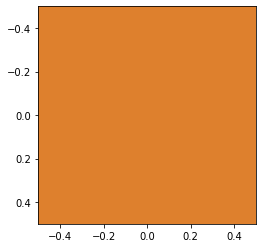

deep orange


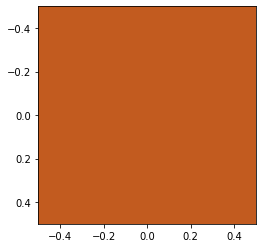

red


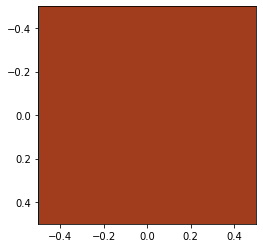

blue


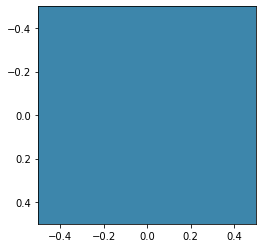

green


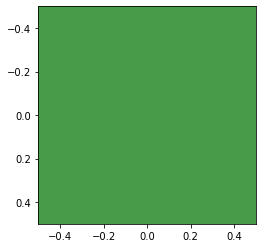

unhappy cat


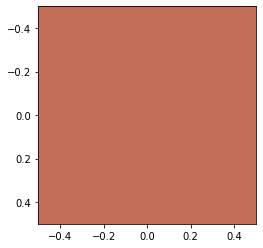

frivolous tree


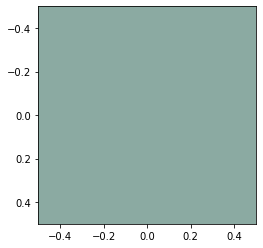

the tree is red


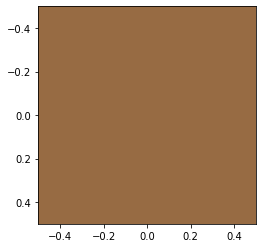

sunny


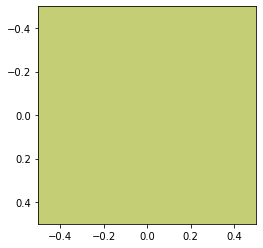

stormy


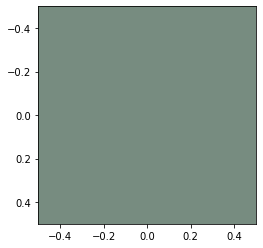

cloudy


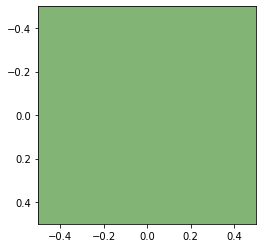

half past sunset


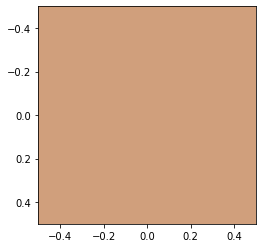

walk by the ocean


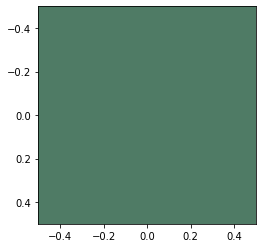

ocean


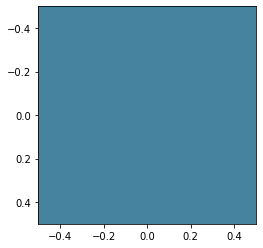

banana


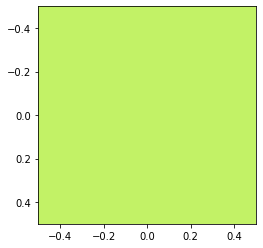

In [434]:
names = ["orange", "deep orange", "red", "blue", "green", "unhappy cat", "frivolous tree",
        "the tree is red", "sunny", "stormy", "cloudy", "half past sunset", "walk by the ocean", "ocean", "banana"]
for name in names:
    chunks = chunk_input(name, 6)
    assign_color(chunks, nnRed, nnGreen, nnBlue)

happy


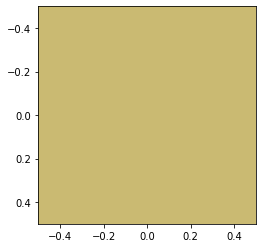

sad


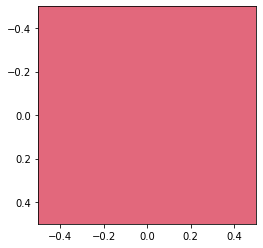

angry


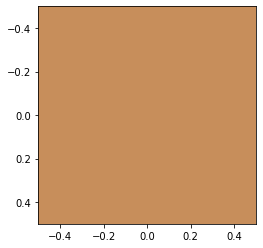

mellow


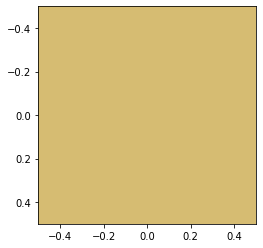

In [435]:
names = ["happy", "sad", "angry", "mellow"]
for name in names:
    chunks = chunk_input(name, 6)
    assign_color(chunks, nnRed, nnGreen, nnBlue)

In [436]:
def load_file(filename):
    '''
    Loads a string from a plain text file.
    Parameters:
    filename (str): path to file

    Returns:
    String : the contents of the file as a string
    '''
    out = ""
    with open(filename, 'r') as f:
        for line in f:
            out += line
    out = out.replace("\n", "")
    return out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


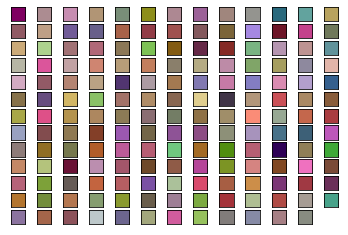

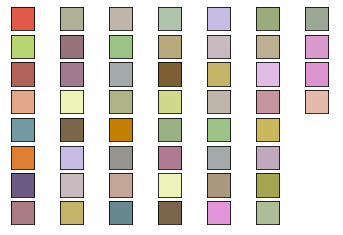

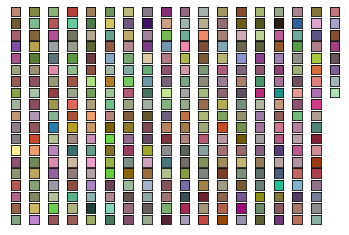

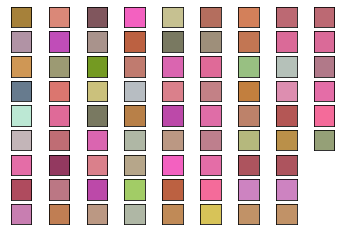

In [439]:
#print palettes of longer texts
texts = [load_file("poe.txt"), load_file("firework.txt"), load_file("moby_dick.txt"), load_file("happy.txt")]
for i in range(0, len(texts)):
    chunks = chunk_input(texts[i], 6)
    assign_color(chunks, nnRed, nnGreen, nnBlue)

# Logistic Regression

In [348]:
def train_lr(X_train, Y_train):
    X_train = X_train.reshape((27773,100*max_name_length))
    model = LogisticRegression(random_state=0)
    model.fit(X_train, Y_train)
    return model

In [349]:
#logistic regression models for each color
lrRed = train_lr(X_train, Y_train_red)
lrGreen = train_lr(X_train, Y_train_green)
lrBlue = train_lr(X_train, Y_train_blue)

/Users/gracebrown/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/gracebrown/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

In [364]:
def assign_color_lr(chunks, modelRed, modelGreen, modelBlue):
    """Generate color from a name.
    For each chunk of data, predicts r g and b values and then prints them out
    """
    #get rgb values for each chunk
    rgbs = []
    for words in chunks:
        color_name = []
        for word in words:
            if word in model_gigaword:
                color_name.append(model_gigaword[word])
            else:
                continue
        
        #pad with empty embedding if color name is not long enough
        empty_embedding = np.zeros(100)
        while len(color_name) < max_tokens:
            color_name.append(empty_embedding)
            
        #flatten out list
        flat_list = [item for sublist in color_name for item in sublist]

        r = modelRed.predict(np.array([flat_list]))[0] * 1.0 / 255

        g = modelGreen.predict(np.array([flat_list]))[0] * 1.0 / 255

        b = modelBlue.predict(np.array([flat_list]))[0] * 1.0 / 255

        rgb = (r, g, b)
        rgbs.append(rgb)
        
    #print single color
    if len(rgbs) == 1:
        print(' '.join(chunks[0]))
        display_color(rgbs[0])
    #print color palette
    else:
        print(title)
        print_color_sequence(rgbs, math.ceil(math.sqrt(len(rgbs))))

orange


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gracebrown/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


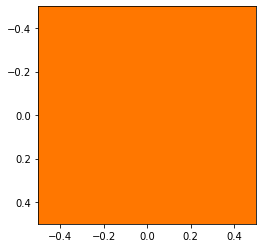

deep orange


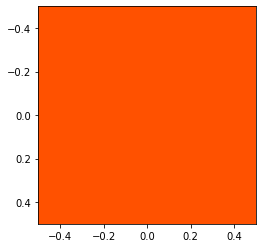

red


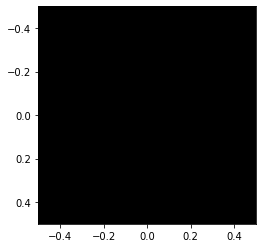

blue


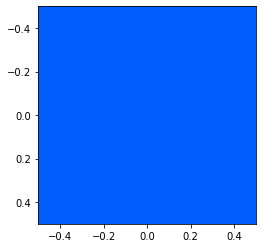

green


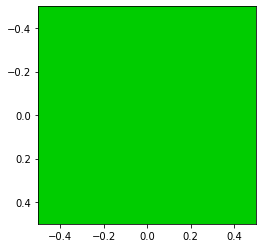

unhappy cat


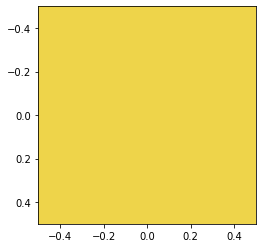

frivolous tree


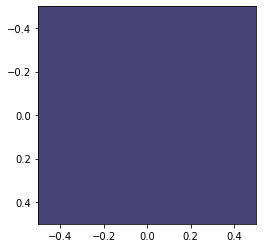

the tree is red


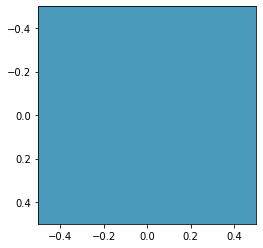

sunny


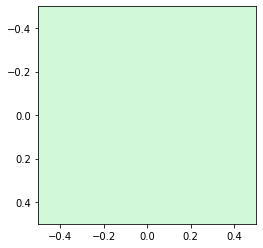

stormy


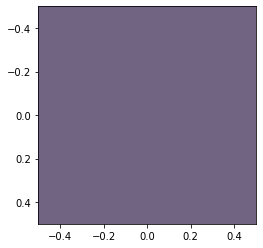

cloudy


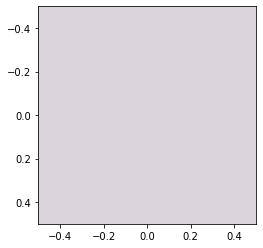

half past sunset


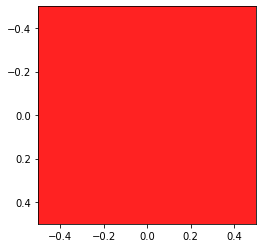

walk by the ocean


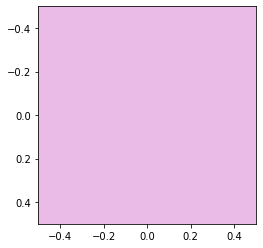

ocean


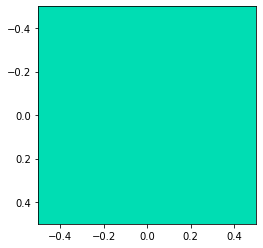

banana


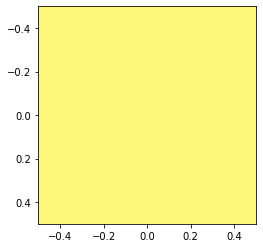

In [417]:
names = ["orange", "deep orange", "red", "blue", "green", "unhappy cat", "frivolous tree",
        "the tree is red", "sunny", "stormy", "cloudy", "half past sunset", "walk by the ocean", "ocean", "banana"]
for name in names:
    chunks = chunk_input(name, 6)
    assign_color_lr(chunks, lrRed, lrGreen, lrBlue)

happy


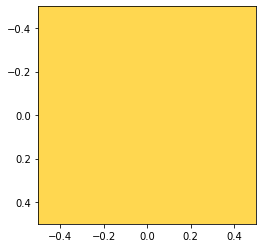

sad


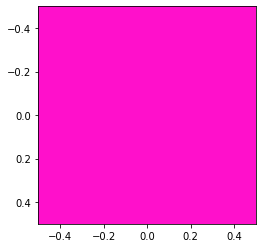

angry


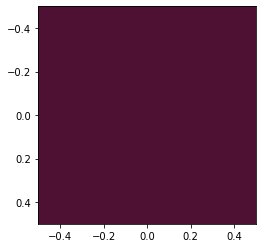

mellow


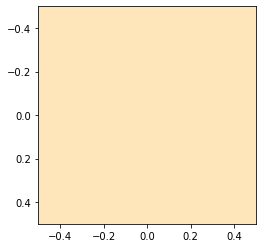

In [369]:
names = ["happy", "sad", "angry", "mellow"]
for name in names:
    chunks = chunk_input(name, 6)
    assign_color_lr(chunks, lrRed, lrGreen, lrBlue)

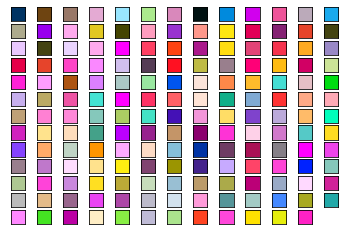

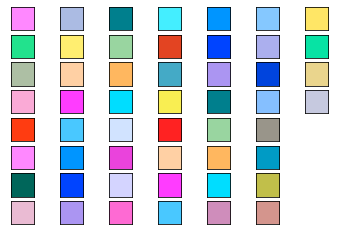

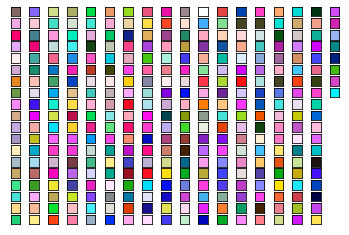

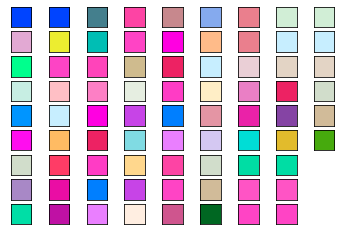

In [355]:
#color palettes for longer texts
texts = [load_file("poe.txt"), load_file("firework.txt"), load_file("moby_dick.txt"), load_file("happy.txt")]
for name in texts:
    chunks = chunk_input(name, 6)
    assign_color_lr(chunks, lrRed, lrGreen, lrBlue)